# Cart-Pole Q-Learning
Notebook for experimenting with a Q-learning strategy for the cart-pole environment.

In [34]:
import gym
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
%matplotlib notebook

## Exploring the environment

In [13]:
env = gym.make('CartPole-v1')
print(env.observation_space)
print(env.action_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


This shows that the state space comprises of 4 numbers:
- position of the cart in the range [-4.8, 4.8]
- velocity of the cart in the range [-inf, inf]
- angle of the pole in the range [-0.418, 0.418] (equivalent to +/- 24 deg)
- angular velocity of the pole in the range [-inf, inf].

The action space is discrete with two values -- 0 to move left, 1 to move right.

Now randomly sample action space and observe the distributions. This will allow for sensible setting of bins for the unbounded variables in the continuous state space.

In [14]:
sample_observations = {'position': [], 'velocity': [], 'angle': [], 'angular_velocity': []}

for episode in tqdm(range(1000)):
    env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        observation, _, done, _ = env.step(action)
        sample_observations['position'].append(observation[0])
        sample_observations['velocity'].append(observation[1])
        sample_observations['angle'].append(observation[2])
        sample_observations['angular_velocity'].append(observation[3])
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


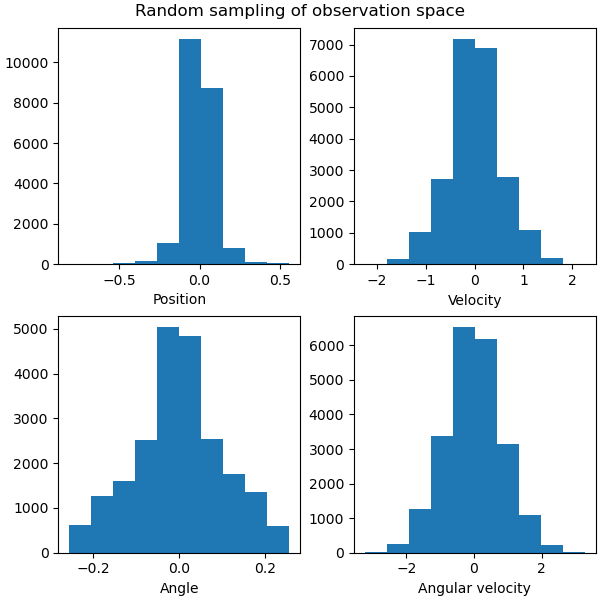

Text(0.5, 0, 'Angular velocity')

In [15]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(6, 6))
axs = axs.flat
axs[0].hist(sample_observations['position'])
axs[1].hist(sample_observations['velocity'])
axs[2].hist(sample_observations['angle'])
axs[3].hist(sample_observations['angular_velocity'])

fig.suptitle('Random sampling of observation space')
axs[0].set_xlabel('Position')
axs[1].set_xlabel('Velocity')
axs[2].set_xlabel('Angle')
axs[3].set_xlabel('Angular velocity')

The bounded state variables (position and angle) can be discretised with the same bounds. The unbounded ones may have bounds inferred from the randomly-sampled distributions. To allow the agent to meaningfully explore the state space, these bounds should at least encompass the width of the randomly-sampled distribution.

In [18]:
# Define the number of bins for each state variable (this is actually n_bins + 1)
n_bins = [6, 6, 6, 6]  # Position, velocity, angle, angular velocity

# Now create the bins
position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_bins[0])
velocity_bins = np.linspace(-5, 5, n_bins[1])
angle_bins = np.linspace(env.observation_space.low[2], env.observation_space.high[2], n_bins[2])
angular_velocity_bins = np.linspace(-5, 5, n_bins[3])

## Create agent
Define a class describing the Q-learning agent and associated methods.

  0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


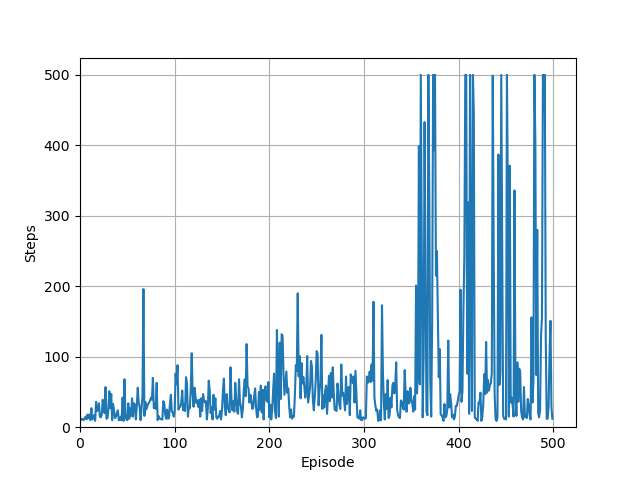

<IPython.core.display.Javascript object>


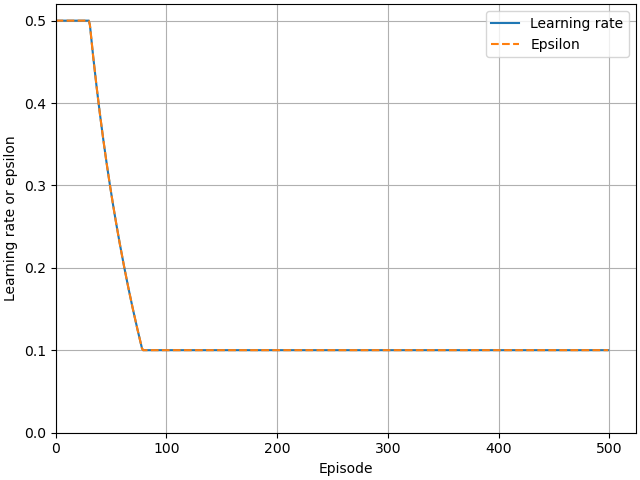

In [71]:
class QAgent:
    """Q-learning agent for cart-pole environment.
    
    """
    def __init__(
        self,
        n_bins=[5, 5, 5, 5],
        lr_init=0.5, lr_min=0.1, lr_decay=10,
        eps_init=0.5, eps_min=0.1, eps_decay=10,
        discount_factor=0.9,
        n_episodes=500,
        progress_bars=True
    ):
        self.n_bins = n_bins
        self.lr_init = lr_init
        self.lr = lr_init
        self.lr_min = lr_min
        self.lr_decay = lr_decay
        self.eps_init = eps_init
        self.eps = eps_init
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.discount_factor = discount_factor
        self.n_episodes = n_episodes
        self.progress_bars = progress_bars
        
        self.rng = default_rng()
        self.env = gym.make('CartPole-v1')
        self.bins = self._create_bins()
        self.Q_table = self._initialise_Q_table()
        
        
    def _initialise_Q_table(self):
        return np.zeros(list(self.n_bins) + [self.env.action_space.n])
        
        
    def _reset(self):
        self.lr = self.lr_init
        self.eps = self.eps_init
        self.Q_table = self._initialise_Q_table()
        
    
    def _create_bins(self):
        """Create bins for discretising the state space.
        
        Returns
        -------
        bins : dict
            Dictionary where keys are the state variable names and values
            are lists of bin edges.
        """
        bins = {
            'position': np.linspace(
                self.env.observation_space.low[0],
                self.env.observation_space.high[0],
                self.n_bins[0]
            ),
            'velocity': np.linspace(-5, 5, self.n_bins[1]),
            'angle': np.linspace(
                self.env.observation_space.low[2],
                self.env.observation_space.high[2],
                self.n_bins[2]
            ),
            'angular_velocity': np.linspace(-5, 5, n_bins[3])
        }        
        return bins
    
    
    def _discretise_state(self, state):
        """Discretise a state by binning the values.
        
        Outliers are considered to be in the nearest edge bin.
        
        Parameters
        ----------
        state : list
            List containing observation of cart-pole state.
        
        Returns
        -------
        tuple
            4-tuple containing bin index of discretised value for each state
            variable.
        """
        # Unpack state observations
        pos_obs, vel_obs, ang_obs, ang_vel_obs = state
        
        # Discretise each one
        def discretise_observation(obs, var):
            discr_obs = np.digitize(
                np.clip(obs, self.bins[var].min(), self.bins[var].max()),
                self.bins[var]
            ) - 1
            return discr_obs
        pos_discr = discretise_observation(pos_obs, 'position')
        vel_discr = discretise_observation(vel_obs, 'velocity')
        ang_discr = discretise_observation(ang_obs, 'angle')
        ang_vel_discr = discretise_observation(ang_vel_obs, 'angular_velocity')
        
        return (pos_discr, vel_discr, ang_discr, ang_vel_discr)
    
    
    def _update_Q_table(self, old_state, new_state, action, reward):
        """Update the Q table using Q-learning algorithm.
        
        Parameters
        ----------
        old_state, new_state : tuple
            Discretised 4-tuple state descriptor.
        action : int
            Action relating `old_state` to `new_state`.
        reward : int
        
        References
        ----------
        - Watkins, C. J. C. H. "Learning from Delayed Rewards" (1989)
          https://www.academia.edu/3294050/Learning_from_delayed_rewards
        - Sutton, R. S. & Barto, A. G. "Reinforcement Learning: An Introduction"
          2nd ed. (2018). Eqn. (6.8).
        """
        self.Q_table[old_state][action] += self.lr * (reward + \
            self.discount_factor * np.max(self.Q_table[new_state]) - \
            self.Q_table[old_state][action])
        
        
    def _epsilon_greedy_action(self, state):
        """Select best guess of optimal action with probability (1 - epsilon).
        Otherwise, sample random action from space of all possible actions.
        
        Returns
        -------
        int
        """
        if self.rng.uniform() > self.eps:
            return np.argmax(self.Q_table[state])
        else:
            return self.env.action_space.sample()
        
        
    def _update_learning_rate(self, episode):
        """Update the learning rate to decay with increasing episode number."""
        new_lr = max(
            self.lr_min,
            min(self.lr_init, 1-np.log10((episode+1)/self.lr_decay))
        )
        return new_lr
        
        
    def _update_epsilon(self, episode):
        """Update the epsilon value to decay with increasing episode number."""
        new_eps = max(
            self.eps_min,
            min(self.eps_init, 1-np.log10((episode+1)/self.eps_decay))
        )
        return new_eps
        
        
    def train(self):
        """Train the Q-learning agent."""
        self.steps = []
        
        episode_gen = range(self.n_episodes)
        if self.progress_bars:
            episode_gen = tqdm(episode_gen)
        
        for episode in episode_gen:
            step = 0
            state = self._discretise_state(self.env.reset())
            done = False
            while not done:
                step += 1
                action = self._epsilon_greedy_action(state)
                new_state, reward, done, _ = self.env.step(action)
                new_state = self._discretise_state(new_state)
                self._update_Q_table(state, new_state, action, reward)
                state = new_state
            
            # Record how well this episode went
            self.steps.append(step)
            
            # Update learning rate and epsilon
            self.lr = self._update_learning_rate(episode)
            self.eps = self._update_epsilon(episode)
        
        env.close()
        
        
    def plot_lr_eps(self):
        """Plot learning rate and epsilon as a function of episode number."""
        lr_plot = [self.lr_init]
        eps_plot = [self.eps_init]
        for e in range(1, self.n_episodes):
            lr_plot.append(self._update_learning_rate(e))
            eps_plot.append(self._update_epsilon(e))
        
        fig, ax = plt.subplots(constrained_layout=True)
        ax.plot(lr_plot, label='Learning rate', c='C0', ls='-')
        ax.plot(eps_plot, label='Epsilon', c='C1', ls='--')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Learning rate or epsilon')
        ax.legend()
        ax.grid()
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        
        
    def plot_progress(self):
        """Plot the learning progress of the agent."""
        fig, ax = plt.subplots()
        ax.plot(self.steps)
        ax.set_xlabel('Episode')
        ax.set_ylabel('Steps')
        ax.grid()
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        
        
test_agent = QAgent()
test_agent.train()
test_agent.plot_progress()
test_agent.plot_lr_eps()